# RJ's VotingSim Quickstart

## Introduction

Back in 2016, when Donald Trump won election to be the President, there was a lot of fussing about illegal voting and electoral voting and young people voting and voting in general. While I have some thoughts about illegal voting (hasn't proved to be a significant problem) and the electoral college ([not great Bob](https://images.app.goo.gl/h93DqB73thZRu6Vh8)) and young people voting (definitely a good thing), something that reall caught my attention was this thing called [*Ranked Choice Voting*](https://en.wikipedia.org/wiki/Ranked_voting).

I probably had heard of it before, but had never considered it fully before the 2016 election, instead believing in the sancity and perfectness of the American election form. But after the election I was thinking: maybe another voting system is better? 

Thus I had the idea for this project, which very naturally I didn't fully pick up until 2023. I only have one goal for this project, and that is to evaluate a number of vote tallying strategies on various population distributions. But other than that, I'm just going to jump right in. Maybe if this ever gets to some stage of completeness I'll come back and write a real description. :)

## Brief Overview of Some Voting Styles
It seems necesary to briefly describe the voting strategies I'm interested in. Just to cover all my bases, all voting situations are made up and all descriptions are *at best* poorly researched.

### Classic
Given a list of $n$ candidates, a voter can select $1$ candidate to vote for. This is seen in the American election style. Whichever candidate receives the most votes is elected (leaving out the possibility of three candidate situations for now, where a plurality would be sufficient to win). I think this situation needs no further explanation.

### Ranked Choice
Given a list of $n$ candidates, a voter can **rank** some number $m$ candidates, where $m \le n$, in the order they would prefer. When votes are tallied, all ballots are counted for the candidate ranked at the top of that specific ballot. If some candidate receives the majority of votes, then great, they win. If not, then the lowest scoring candidate is eliminated. Any ballots with the eliminated candidate specified have that entry crossed off, and tallying happens again with $n-1$ candidates.

**An example:** Let us assume there are 3 candidates: Arty, Bella, and Christy. Let us consider 5 voter, who will be numbered for simplicity. Let's say in this format each voter can specify 2 candidates in their preferred order. Voting might look like this:

1. Arty, Chirsty
2. Bella, Arty
3. Christy, Arty
4. Arty, Bella
5. Bella, Christy

After the first round of voting we have the following tally:
| Candidate | Votes |
|-----------|-------|
| Arty      | 2     |
| Bella     | 2     |
| Christy   | 1  

Ah shoot! No one wins. Well now we eliminate the lowest scoring candidate (Bye Christy, it was you refusal to say puppies are cute that doomed you). So now we need to refresh our ballots:
1. Arty, ~~Chirsty~~
2. Bella, Arty
3. ~~Christy~~, Arty
4. Arty, Bella
5. Bella, ~~Christy~~

Voter 3's previous preference for Cristy is discarded, and their ballot now counts for their second option: Arty. So now our tally looks like:
| Candidate | Votes |
|-----------|-------|
| Arty      | 3     |
| Bella     | 2     |

Woohoo we have a winner. Some things about ranked choice:

- It allows voters to vote for an unpopular candidate whom they prefer, without throwing away votes as happens in a 2 candidate system like the US.
- Allows voters to indicate a preference for some candidate over another, while still giving support to that second candidate 

### Approval
Given a list of $n$ candidates, a vote can choose of up to $n$ that they would **approve** of winning the election. The winner of the election is the candidate with the most overall "approvals". 

**An example:** Let us re-use our 3 candidates from before: Arty, Bella, and Christy, as well as our 5 numbered voters. Each voter may select up to 3 that they approve of on their ballot. So the ballots may look like this:

1. Arty, Bella, Chirsty
2. Arty, Bella
3. Arty
4. Arty, Bella
5. Christy

Then our final tally is:

1. Arty - 4 votes
2. Bella - 3 votes
3. Christy - 2 votes

## Lets write some code
Ok enough jibber jabber, lets start defining our simulator. Wait first some imports and such.

Also if it wasn't obvious, I'm using this project as an opportunity to teach myself some libraries.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import math
%matplotlib inline

Well, actually, maybe lets think through some requirements for now.

I want to start with a purely 1-D system. Each voter and candidate will fall somewhere on the real number line which represents their position on some issue. Maybe it's Democrat vs Republican, maybe its coffee vs tea, or maybe it's people who don't use turn signals should be violently executed vs ... not that.

The idea is eventually compare these voting algorithms on a variety of probability distributions from which we will sample our population of voters. It'll be easiest if we have our center at 0 and let's restrict our candidates to the range $[-4, 4]$, choosen because on a normal curve with mean $\mu = 0$ and standard deviation $\sigma = 1$, the probability of selecting a value outside that range is effectively 0.

For now let's just hardcode some stuff, we can come back and be general later.

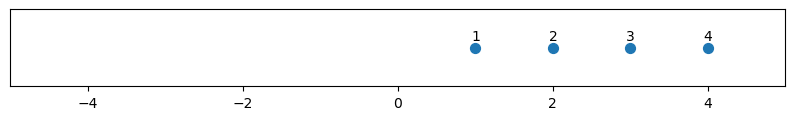

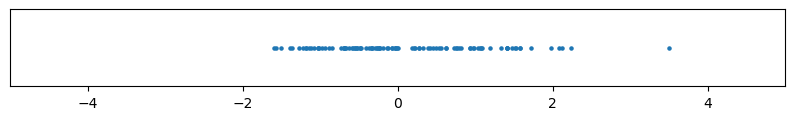

In [20]:
# Quickly, a number line plotting function might be helpful, so lets just do that quickly
def number_line_plot(x, text_labels=None, text_size=10, dot_size=50, x_lim=[-5,5]):
    fig, ax = plt.subplots()
    plt.scatter(np.array(x), np.zeros(x.shape), s=dot_size)
    fig.set_figheight(1)
    fig.set_figwidth(10)
    ax.set_xlim(x_lim)
    ax.set_ylim([-1,1])
    ax.get_yaxis().set_visible(False)

    if text_labels is not None and x.size==len(text_labels):
        for i, label in enumerate(text_labels):
            ax.annotate(label, (x[i]-(len(label) * 0.05), 0.2), fontsize=text_size)
    return ax

ax = number_line_plot(np.array([1,2,3,4]), text_labels=['1', '2', '3', '4'])
plt.show()
ax = number_line_plot(np.random.normal(size=(100,)), dot_size=5)

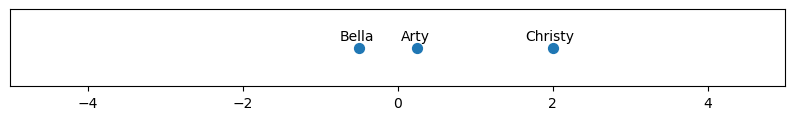

In [21]:
candidates = {'Arty': 0.25,
              'Bella': -0.5,
              'Christy': 2}

ax = number_line_plot(np.array(list(candidates.values())), text_labels=candidates.keys())

Ok now let's think about our voters. Like our candidates, they're represented by a location on the number line showing where they fall on our non-offensive political issue. However it is worth explicitly laying out how the position of a voter relates to their voting behavior. A voter at position $x$ wants to vote for the candidate that minimizes $\mid x - c \mid$, where $c$ is the position of the candidate.

In a classic election (America style) that means our citizen votes for the closest candidate to their position. For ranked choice voting, the voters top choice would be the closest to their position, the second choice would be the second closest, etc...

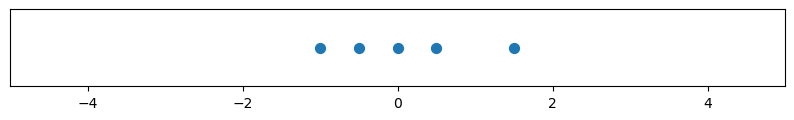

In [22]:
voters = np.array([-1, -.5, 0, 0.5, 1.5])

ax = number_line_plot(voters)

It might be worth updating our plotting method to more easily display both candidates and voters

<Axes: >

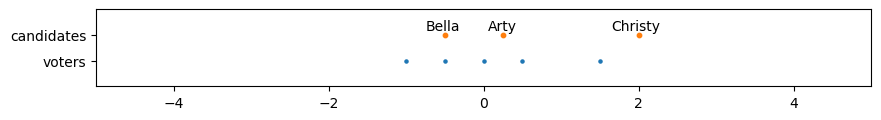

In [23]:
def number_line_plot_2(values1, values2, **kwargs):
    # values1 is candidates
    # values2 is voters
    # who knows if this was the best way to make this happen

    fig, ax = plt.subplots()
    dot_size = kwargs['dot_size'] if 'dot_size' in kwargs.keys() else [10,5]
    x_lim = kwargs['x_lim'] if 'x_lim' in kwargs.keys() else [-5,5]
    text_labels = kwargs['text_labels'] if 'text_labels' in kwargs.keys() else None
    text_size = kwargs['text_size'] if 'text_size' in kwargs.keys() else 10

    plt.scatter(np.array(values2), np.zeros(values2.shape), s=dot_size[1])
    plt.scatter(np.array(values1), np.ones(values1.shape), s=dot_size[0])

    fig.set_figheight(1)
    fig.set_figwidth(10)
    ax.set_xlim(x_lim)
    ax.set_ylim([-1,2])
    # ax.get_yaxis().set_visible(False)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['voters', 'candidates'])

    # For now only setup labels for candidates
    if text_labels is not None and values1.size==len(text_labels):
        for i, label in enumerate(text_labels):
            ax.annotate(label, (values1[i]-(len(label) * 0.05), 1.2), fontsize=text_size)
    return ax

number_line_plot_2(np.array(list(candidates.values())), voters, text_labels=candidates.keys())

Great, now we have a much better picture of our particular voting situation. Just a quick visual check shows what we might expect to happen in this situation. In a classic voting situation, each of Bella and Arty would receive the two votes of the candidates closest to them, while Christy would receive the vote of that right-most voter. So we'd end up with vote tallies of [2, 2, 1], meaning no candidate would win outright.

With ranked choice however, we would eliminate Christy after one round of voting, at which point that voter's ballot would switch to Arty, giving him the win.

I'd also quickly like to make a histogram version of the pervious plot. It's not quite as good for small numbers, since you can't see a user's exact position. But it does lend more clarity for large populations.

<Axes: >

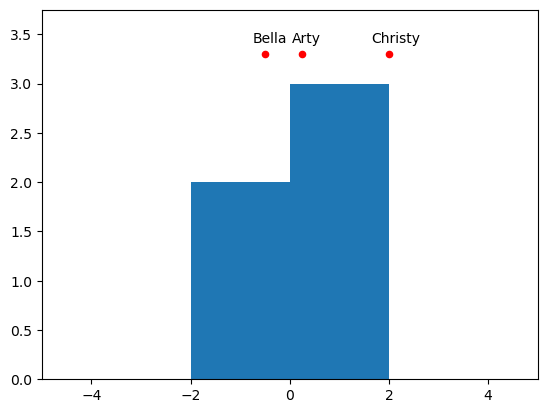

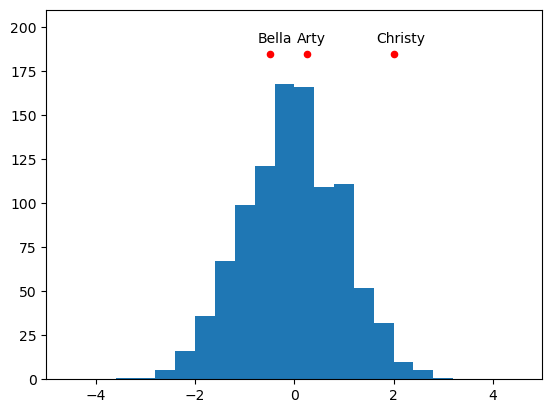

In [24]:
def histogram_plot(values1, values2, **kwargs):
    fig, ax = plt.subplots()
    dot_size = kwargs['dot_size'] if 'dot_size' in kwargs.keys() else 20
    x_lim = kwargs['x_lim'] if 'x_lim' in kwargs.keys() else [-5,5]
    text_labels = kwargs['text_labels'] if 'text_labels' in kwargs.keys() else None
    text_size = kwargs['text_size'] if 'text_size' in kwargs.keys() else 10

    # coming up with a random function to determine the number of bins that passes the eye test for low numbers of voters and high numbers
    counts, bins = np.histogram(values2, range=(-4,4), density=False, bins=math.floor(3*math.log(len(values2))))
    ax.stairs(counts, bins, fill=True)
    plt.scatter(np.array(values1), np.ones(values1.shape)* max(counts) * 1.1, s=dot_size, c='r')

    # For now only setup labels for candidates
    if text_labels is not None and values1.size==len(text_labels):
        for i, label in enumerate(text_labels):
            ax.annotate(label, (values1[i]-(len(label) * 0.05), max(counts) * 1.14), fontsize=text_size)
            
    ax.set_xlim(x_lim)
    ax.set_ylim([0, max(counts) * 1.25])
    return ax

histogram_plot(np.array(list(candidates.values())), voters, text_labels=candidates.keys())
histogram_plot(np.array(list(candidates.values())), np.random.normal(size=(1000,)), text_labels=candidates.keys())

## Voting Machines

It seems like the right time to start describing our voting algorithms, which I shall call *voting machines*. Seems appropriate.

Let's start with a classic voting situation. 

In [25]:
def classic_voting_machine(candidates, voters):
    # candidates is a numpy array of shape (N,)
    # voters is a numpy array of shape (M,)

    # compute distances from all candidates to all voters
    diffs = np.absolute(np.array([[c - v for c in candidates] for v in voters]))

    # returns the index of the candidate each voter is voting for
    am = np.argmin(diffs, axis=1)

    c_ndx, counts = np.unique(am, return_counts=True)
    
    final_tally = np.zeros(candidates.shape)
    for i in range(len(c_ndx)):
        final_tally[c_ndx[i]] = counts[i]
    return final_tally

print(classic_voting_machine(np.array([1,2]), np.array([0, 1.6, 2.2])))
print(classic_voting_machine(np.array([-1, 1]), np.arange(10))) # includes 0, and tiebreak might go to candidate at -1

[1. 2.]
[1. 9.]


Wonderful, I think our classic voting machine is working. Lets do ranked choice. The process for this at first is a bit more daunting, but there does seem to be a nice way to simplify everything if we throw performance out the window. And since my goal is to use a handful of candidates and a couple thousand voters (represented by simple ints), I think we can accept that for now.

We should get a bit more rigourous with our notation. Let $c$ denote a candidate and $v$ denote a voter. Lets define a function $P(x)$ that yields the positions of both candidates and voters. 

The simplification I'm going to make assumes that each voter prefers candidates according to a candidate's proximity to the voters location. Maybe a bit more technically, a voter with position $v$ will have an ordered sequence of candidates to vote for: $S_v = {c_1^v, c_2^v, c_3^3,...}$ where $\mid P(c_1^v) - P(v) \mid \le \mid P(c_2^v) - P(v) \mid \le \mid P(c_3^v) - P(v) \mid \le ...$

As a quick aside, this obviously doesn't map directly real elections. A certain politician may have policies more conforming to my politics, but I may prefer another candidate for any number of reasons such as age, number of sexual assault cases, spray on tan status, etc.

Anyways. If we consider a ranked choice election with 3 candidates, it's obvious that the result of the first vote is the same as classic voting: each voter ranks the candidate closest to their position as their top choice. Now lets assume that no candidate reached a majority, as we have to eliminate a candidate, call them $c_{loser}$. Well the voters who ranked $c_{loser}$ as their top choice would now have their ballot default to their second choice. This is the candidate from the set of candidates *minus* $c_{loser}$. So, for this second round we can just use our classic voting machine again, but on subset of candidates that are still in the election. This logic applies to more and more eliminations until we are left with 2, allowing us to gracefully reuse code (fuck ya).

One last note. I'd like to not delete candidates from the input list, as I'm using the indexing to determine who is who. So instead of deleting, I'm going to simply change their position to `np.inf`. It should be obvious why this works: by setting a candidates position to infinity, they automatically move to the bottom of every voters rankings. Any candidate remaining in election would be higher ranked, even if they are on the other side of our made up spectrum. So for all intents and purposes they are deleted. This does come with the caveat of having to keep track of how many we've deleted and using some fun logic to make sure we don't try and delete an already deleted candidate. But that's ok.

In [26]:
def ranked_choice_voting_machine(candidates, voters):
    candidates = copy.deepcopy(candidates) # this is necesary since we mutate the array when we set the losing candidate to np.inf
    majority = False
    num_voters = voters.size
    num_deleted = 0
    while not majority:
        tallies = classic_voting_machine(candidates, voters)
        majority = np.max(tallies) >= (num_voters/2)
        if majority:
            return tallies

        # no majority, elimiate candidate
        loser = np.argsort(tallies)
        candidates[loser[0 + num_deleted]] = np.inf
        num_deleted+=1
        if np.all(candidates==np.inf):
            print("Eliminated all candidates, something messed up")
            return np.array([0])

print(ranked_choice_voting_machine(np.array([0,1,2], dtype='float'), np.array([-0.1, 0.1, 0.9, 1.1, 2.5], dtype='float')))
print(ranked_choice_voting_machine(
    np.arange(-3,3, dtype='float'),
    np.array([-3, -2, -1, -0.25, 0.25, 1, 2, 3], dtype='float')
))

[2. 3. 0.]
[0. 3. 0. 5. 0. 0.]


How do we handle approval voting? With classic, each voter chose the candidate closest to them on the scale. In ranked choice, we had each voter list all the candidates in order by their position proximity. But in approval we have to make another design decision: Where is the cutoff between approve and not approve?

For now, I'm just going to make some assumptions, but we can come back later and edit theses. 

1. Voters will always approve of at least one candidate. Otherwise why show up?
2. ~~Voters approve of each candidate within $1$ unit of their position on the axis.~~ I've decided to change this to 2. Our range is [-4, 4], so 1 seems too small to be realistic. 

Let's set these values in their own cell, so we can easily edit them in the future.

In [27]:
MIN_CANDIDATES_APPROVED = 1
APPROVAL_VOTING_RANGE = 2

In [28]:
def approval_voting_machine(candidates, voters, approval_voting_range_self=None):

    # Just so we have the easy ability to overwrite APPROVAL_VOTING_RANGE for one offs
    approval_voting_range_self = APPROVAL_VOTING_RANGE if approval_voting_range_self is None else approval_voting_range_self

    # compute distances from all candidates to all voters
    diffs = np.absolute(np.array([[c - v for c in candidates] for v in voters]))
    approvals = diffs <= APPROVAL_VOTING_RANGE

    # We need to find rows in approvals with sum = 0, since these voters provisionally vote for less than MIN_CANDIDATES_APPROVED candidates.
    # We should have these voters vote for the MIN_CANDIDATES_APPROVED number of candidates.
    not_enough_approvals = np.where(np.sum(approvals, axis=1) < MIN_CANDIDATES_APPROVED)

    for voter_ndx in not_enough_approvals:
        
        # get candidates distances from this voter
        cand_dists = diffs[voter_ndx, :]
        ordered_ndx = np.argsort(cand_dists).flatten()
        approvals[voter_ndx, ordered_ndx[:MIN_CANDIDATES_APPROVED]] = True

    votes = np.sum(approvals, axis=0)
    return votes

print(
    approval_voting_machine(
        np.array([0, 0.5, 1]),
        np.array([-0.3, -0.1, 0.3, 0.4, 0.6, 0.9, 1.1, 1.6, 1.8, 3])
    )
)

[ 9  9 10]


Ok before we get tooooooo far down the rabbit hole, I'd like to just take a moment and do some sanity testing. 

[465.  35.]
[465.  35.]
[490  80]


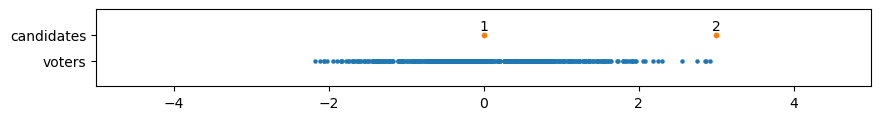

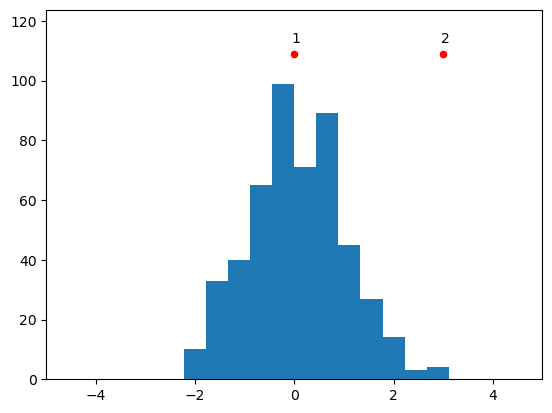

In [29]:
candidates = np.array([0, 3], dtype='float')
voters = np.random.normal(size=(500,))

number_line_plot_2(candidates, voters, text_labels=['1', '2'])
histogram_plot(candidates, voters, text_labels=['1', '2'])
print(classic_voting_machine(candidates, voters))
print(ranked_choice_voting_machine(candidates, voters))
print(approval_voting_machine(candidates, voters))

[135. 334.  31.]
[135. 334.  31.]
[422 477  78]


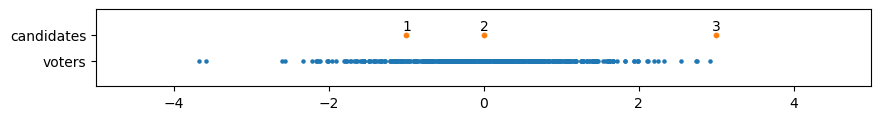

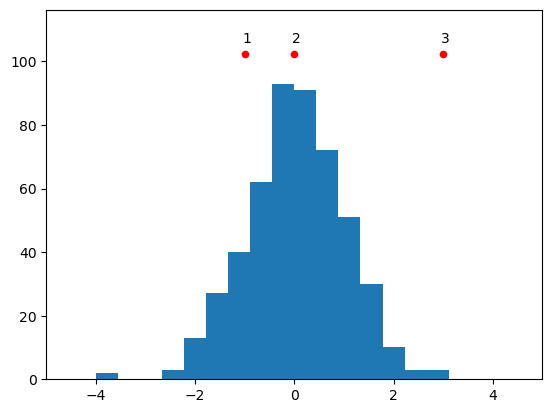

In [30]:
candidates = np.array([-1, 0, 3], dtype='float')
voters = np.random.normal(size=(500,))

number_line_plot_2(candidates, voters, text_labels=['1', '2', '3'])
histogram_plot(candidates, voters, text_labels=['1', '2', '3'])
print(classic_voting_machine(candidates, voters))
print(ranked_choice_voting_machine(candidates, voters))
print(approval_voting_machine(candidates, voters))

[207. 150. 143.]
[207. 293.   0.]
[458 470 424]


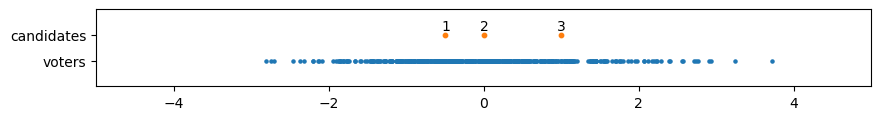

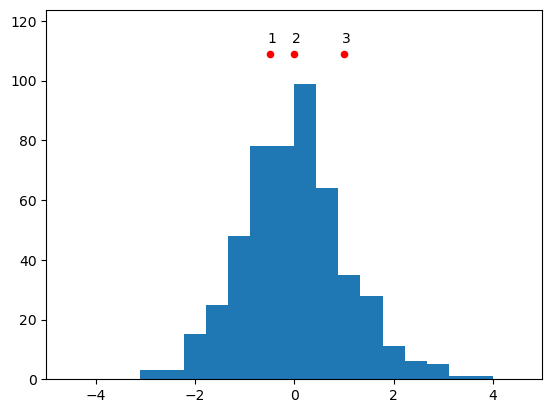

In [31]:
candidates = np.array([-0.5, 0, 1], dtype='float')
voters = np.random.normal(size=(500,))

number_line_plot_2(candidates, voters, text_labels=['1', '2', '3'])
histogram_plot(candidates, voters, text_labels=['1', '2', '3'])
print(classic_voting_machine(candidates, voters))
print(ranked_choice_voting_machine(candidates, voters))
print(approval_voting_machine(candidates, voters))

Interestingly enough, we're already seeing some interesting effects. If we consider that last case, we would expect candidate $2$ to win any election, as they are the central candidate on a normal distribution. But they lose the classic election and the ranked choice voting election. 

## Interesting Situations

### Normal Distribution with Slightly Slanted Candidates

The first scenario I want to look at is a softball. Lets take 50,000 voters sampled from a normal distribution and see how they vote between two candidates, one of which is slightly more center than the other.

Classic Voting:
candidate      | vote count  | percentage
1              | 24419       | 48.84%
2              | 25581       | 51.16%

Ranked Choice Voting
candidate      | vote count  | percentage
1              | 24419       | 48.84%
2              | 25581       | 51.16%

Approval Voting
candidate      | vote count  | percentage
1              | 41932       | 83.86%
2              | 42783       | 85.57%


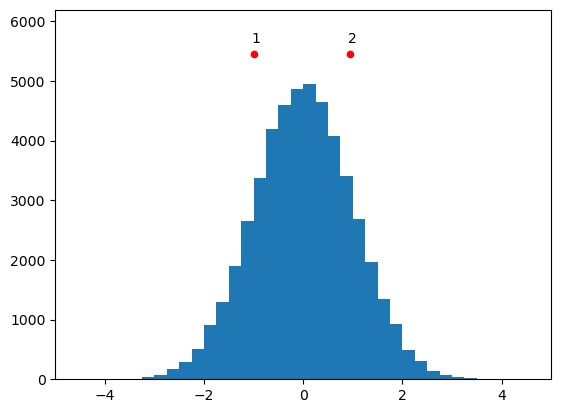

In [32]:
def run_election(candidates, voters, machine, text_labels=None):
    text_labels = list(range(1, candidates.size + 1)) if text_labels==None else text_labels
    counts = machine(candidates, voters)
    print("candidate      | vote count  | percentage")
    for i, label in enumerate(text_labels):
        str_label = str(label).ljust(14)
        str_count = str(int(counts[i])).ljust(11)
        str_per = str(np.round(100*counts[i]/voters.size, 2))
        print("{} | {} | {}%".format(str_label, str_count, str_per))


candidates = np.array([-1, 0.95])
number_voters = 50000
voters = np.random.normal(0, 1, number_voters)

histogram_plot(candidates, voters, text_labels=['1', '2'])

print("Classic Voting:")
run_election(candidates, voters, classic_voting_machine)
print("\nRanked Choice Voting")
run_election(candidates, voters, ranked_choice_voting_machine)
print("\nApproval Voting")
run_election(candidates, voters, approval_voting_machine)

This is probably about what we expected. The vote is fairly evenly split, with a slight tilt towards the candidate who is closer to the center. The takeaway from this is pretty obvious: if it's a two candidate election on a normally distributed population, it pays to be more toward the center.

### Normal Distribution with 3 candidates

The next scenario I want to look into is a 3 candidate race on a normally distributed population. The first two candidates will be like in our last scenario (one slightly more tilted toward the center), but the last will be a radical on the side of the more central candidate.

Classic Voting:
candidate      | vote count  | percentage
1              | 24625       | 49.25%
2              | 21860       | 43.72%
3              | 3515        | 7.03%

Ranked Choice Voting
candidate      | vote count  | percentage
1              | 24625       | 49.25%
2              | 25375       | 50.75%
3              | 0           | 0.0%

Approval Voting
candidate      | vote count  | percentage
1              | 42094       | 84.19%
2              | 42521       | 85.04%
3              | 24868       | 49.74%


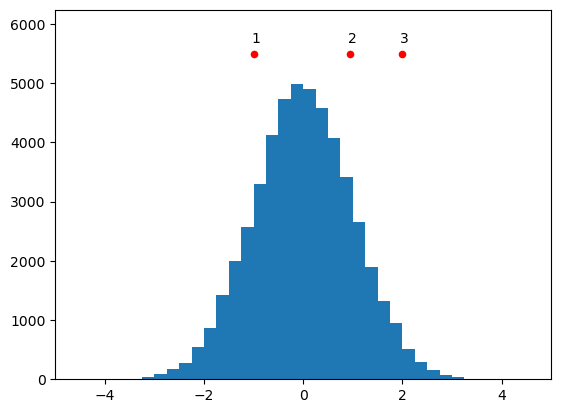

In [33]:
candidates = np.array([-1, 0.95, 2])
number_voters = 50000
voters = np.random.normal(0, 1, number_voters)

histogram_plot(candidates, voters, text_labels=['1', '2', '3'])

print("Classic Voting:")
run_election(candidates, voters, classic_voting_machine)
print("\nRanked Choice Voting")
run_election(candidates, voters, ranked_choice_voting_machine)
print("\nApproval Voting")
run_election(candidates, voters, approval_voting_machine)

I think this is fairly interesting. As shown in the first scenario, candidate 2 should be the best as they (ever so slightly) represent a larger share of the population. But candidate 3 plays the spoiler part, stealing the far right votes from candidate 2. This results in candidate 1 winning the classic election.

As we might expect though, this phenomenon is eliminated in ranked choice voting. When no candidate wins outright, candidate 3 is eliminated and we proceed with 2 candidates. As we've already seen this results in a win for candidate 2.

Also what might be expected is that approval voting gives a win for candidate 2. The interesting thing about this is looking at the approval counts for each candidate. Obviously candidate 3 is far below the other two, but we can see that both candidate 1 and 2 have more than 80% of voters that approve of them. 

### Divided Normal Distribution

For this next scenario, I want to look at what I'm going to call a "divided normal distribution". Essentially I'm going offest the normal distribution by adjusting the mean, and then multiply the output values by either 1 or -1 randomly. This should create a population roughly normal distribution shaped, but with a dip in the middle. I want to try to represent the polarity (or perceived polarity) of modern politics.

To start, we'll do this simulation with our slightly offset candidates.

Classic Voting:
candidate      | vote count  | percentage
1              | 24620       | 49.24%
2              | 25380       | 50.76%

Ranked Choice Voting
candidate      | vote count  | percentage
1              | 24620       | 49.24%
2              | 25380       | 50.76%

Approval Voting
candidate      | vote count  | percentage
1              | 37486       | 74.97%
2              | 37874       | 75.75%


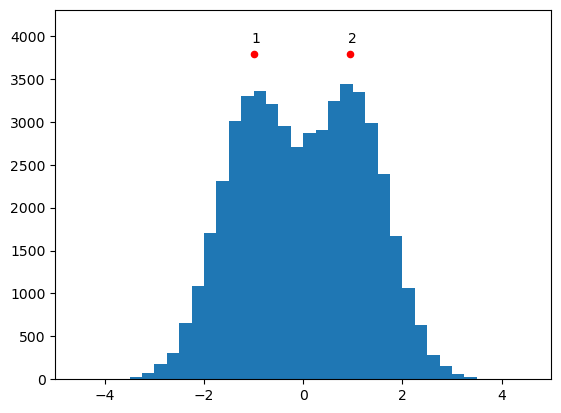

In [34]:
candidates = np.array([-1, 0.95])
number_voters = 50000
voters = np.random.normal(-1, 0.75, number_voters) * np.random.choice([-1, 1], size=number_voters, replace=True)

histogram_plot(candidates, voters, text_labels=['1', '2'])

print("Classic Voting:")
run_election(candidates, voters, classic_voting_machine)
print("\nRanked Choice Voting")
run_election(candidates, voters, ranked_choice_voting_machine)
print("\nApproval Voting")
run_election(candidates, voters, approval_voting_machine)

Once again, we have candidate 2 winning. This should probably be expected as the deciding vote are just the ones in the center which have a slight preference for candidate 2.

### Divided Normal Distribution on 3 Candidates

Let's look at the same population as the last scenario, but with 3 candidates.

Classic Voting:
candidate      | vote count  | percentage
1              | 19285       | 38.57%
2              | 11193       | 22.39%
3              | 19522       | 39.04%

Ranked Choice Voting
candidate      | vote count  | percentage
1              | 24740       | 49.48%
2              | 0           | 0.0%
3              | 25260       | 50.52%

Approval Voting
candidate      | vote count  | percentage
1              | 37368       | 74.74%
2              | 45472       | 90.94%
3              | 38123       | 76.25%


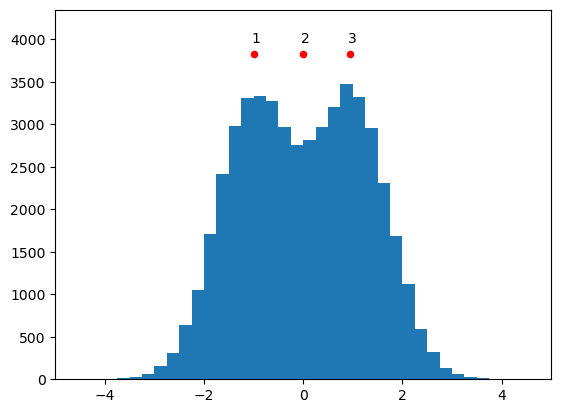

In [35]:
candidates = np.array([-1, 0, 0.95])
number_voters = 50000
voters = np.random.normal(-1, 0.75, number_voters) * np.random.choice([-1, 1], size=number_voters, replace=True)

histogram_plot(candidates, voters, text_labels=['1', '2', '3'])

print("Classic Voting:")
run_election(candidates, voters, classic_voting_machine)
print("\nRanked Choice Voting")
run_election(candidates, voters, ranked_choice_voting_machine)
print("\nApproval Voting")
run_election(candidates, voters, approval_voting_machine)

This is a fun scenario because of the results vs what is probably the best situation for the whole population. If we look at the plot, we see that a vast majority are within 2 units of 0. Given this, we might expect candidate 2 (the one located directly at 0) to be the best potential winner for the population as a whole. And actually this is reflected in the approval voting tally, where candidate 2 beats candidates 1 and 3 by almost 15% each. 

But in normal voting we see candidate 3 winning. This again seems to be because of their slighly closer location to the center. But this time they also get a benefit by being on an open side (no candidate farther to the right) meaning that every voter on that side of the axis votes for candidate 4. Likewise candidate 1 benefits from being on an open side, getting many more voters than candidate 2.

Since candidate 2 is effectively boxed out in the normal election, it makes sense that they are the first eliminated in the ranked choice voting, which ultimately is won by candidate 3. But it is discouraging to this idea that's subtely been building up this whole time: that ranked choice voting leads to the ideal outcome for a majority of the population. We can take some solace in that it's at least as good as normal voting, but now we know there are situations in which A) ranked choice voting is flawed and B) approval voting is actually the ideal method.